In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timezone
from dataclasses import dataclass szsibazefssss

In [74]:
#url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=json-pretty"
url = "active.json"
data = pd.read_json(url).to_numpy()

In [75]:
from dataclasses import dataclass
import numpy as np
from datetime import datetime, timezone
import pytz

@dataclass
class Satellite:
    NAME: str
    NORA_ID: int
    EPOCH: str
    MEAN_MOTION: float
    ECCENTRICITY: float
    INCLINATION: float
    RA_OF_ASC_NODE: float
    ARG_OF_PERICENTER: float
    MEAN_ANOMALY: float    
    MUE: float = 398600.44
    EARTH_MASS: float = 5.972e24
    G: float = 6.67384e-11
    NB_POINTS: int = 1000
    NB_ORBITS: int = 1
    
    def __post_init__(self):
        self.d1 = datetime(int(self.EPOCH[:4]),
                           int(self.EPOCH[5:7]),
                           int(self.EPOCH[8:10]),
                           int(self.EPOCH[11:13]),
                           int(self.EPOCH[14:16]),
                           int(self.EPOCH[17:19]))
        self.ECCENTRICITY = np.deg2rad(self.ECCENTRICITY)
        self.INCLINATION = np.deg2rad(self.INCLINATION)
        self.RA_OF_ASC_NODE = np.deg2rad(self.RA_OF_ASC_NODE)
        self.ARG_OF_PERICENTER = np.deg2rad(self.ARG_OF_PERICENTER)
        self.MEAN_ANOMALY = np.deg2rad(self.MEAN_ANOMALY)
        self.d2 = datetime.now(timezone.utc)
        self.dt = (self.d2 - self.d1.replace(tzinfo=pytz.UTC)).seconds
        self.PERIOD = (1 / self.MEAN_MOTION) * 24 * 60 * 60
        self.time = np.arange(0, self.NB_ORBITS * self.PERIOD, self.NB_ORBITS * self.PERIOD / self.NB_POINTS)
        self.MEAN_MOTION_SI = 2 * np.pi / self.PERIOD
        self.SEMI_MAJOR_AXIS = ((self.MUE / (self.MEAN_MOTION_SI ** 2)) ** (1 / 3)) * 1000
        self.MEAN_MOTION = np.sqrt(self.EARTH_MASS * self.G / self.SEMI_MAJOR_AXIS ** 3)
        self.MEAN_ANOMALY = self.MEAN_ANOMALY + self.MEAN_MOTION * self.dt
    
    def future_it(self):
        self.MEAN_ANOMALY_future = self.MEAN_ANOMALY + self.MEAN_MOTION * self.time
        self.ECC_ANOMALY_future = np.zeros_like(self.MEAN_ANOMALY_future)
        epsilon = 1e-6

        for i in range(self.NB_POINTS):
            ECCENTRIC_ANOMALY_N = self.MEAN_ANOMALY_future[i]
            convergence = 1
            
            while convergence > epsilon:
                # Calcul de l'anomalie excentrique en combinant les étapes de Newton-Raphson
                delta = (ECCENTRIC_ANOMALY_N - self.ECCENTRICITY * np.sin(ECCENTRIC_ANOMALY_N) 
                        - self.MEAN_ANOMALY_future[i]) / (1 - self.ECCENTRICITY * np.cos(ECCENTRIC_ANOMALY_N))
                
                ECCENTRIC_ANOMALY_N -= delta
                convergence = np.abs(delta)
            
            # Stocker l'anomalie excentrique calculée
            self.ECC_ANOMALY_future[i] = ECCENTRIC_ANOMALY_N

    def R_INCLINATION(self):
        return np.array([[1,0,0],
                        [0,np.cos(-self.INCLINATION),np.sin(-self.INCLINATION)],
                        [0,-np.sin(-self.INCLINATION),np.cos(-self.INCLINATION)]])
    def R_RA_OF_ASC_NODE(self):
        return np.array([[np.cos(-self.RA_OF_ASC_NODE),np.sin(-self.RA_OF_ASC_NODE),0],
                            [-np.sin(-self.RA_OF_ASC_NODE),np.cos(-self.RA_OF_ASC_NODE),0],
                            [0,0,1]])
    def R_ARG_OF_PERICENTER(self):
        return np.array([[np.cos(-self.ARG_OF_PERICENTER),np.sin(-self.ARG_OF_PERICENTER),0],
                            [-np.sin(-self.ARG_OF_PERICENTER),np.cos(-self.ARG_OF_PERICENTER),0],
                            [0,0,1]])


In [76]:
sat = Satellite(*data[19][:9])
sat.future_it()

In [77]:
r=list(sat.SEMI_MAJOR_AXIS*(1-sat.ECCENTRICITY*np.cos(sat.ECC_ANOMALY_future)))
x=list(sat.SEMI_MAJOR_AXIS*(np.cos(sat.ECC_ANOMALY_future)-sat.ECCENTRICITY))
y=list(sat.SEMI_MAJOR_AXIS*np.sqrt(1-sat.ECCENTRICITY**2)*np.sin(sat.ECC_ANOMALY_future))
x_dot=list(-np.sin(sat.ECC_ANOMALY_future)*sat.MEAN_MOTION*sat.SEMI_MAJOR_AXIS**2/r)
y_dot=list(np.sqrt(1-sat.ECCENTRICITY**2)*np.cos(sat.ECC_ANOMALY_future)*sat.MEAN_MOTION*sat.SEMI_MAJOR_AXIS**2/r)

In [78]:
pos=sat.R_RA_OF_ASC_NODE()@sat.R_INCLINATION()@sat.R_ARG_OF_PERICENTER()@np.array([x,y,np.zeros_like(x)])
vit=sat.R_RA_OF_ASC_NODE()@sat.R_INCLINATION()@sat.R_ARG_OF_PERICENTER()@np.array([x_dot,y_dot,np.zeros_like(x_dot)])

In [79]:
for ind_i, t in enumerate(sat.time):
    fi_earth=(sat.dt+t)*2*np.pi*(1 + 1/365.25)/(3600*24)
    Rot = np.array([[np.cos(fi_earth), np.sin(fi_earth),0],
                    [-np.sin(fi_earth),np.cos(fi_earth),0],
                    [0,0,1]])
    pos[:,ind_i]=Rot@pos[:,ind_i]
    vit[:,ind_i]=Rot@pos[:,ind_i]

In [80]:
def calculate_GMST(sat):
        # Calculate the Julian Date (JD) for the given date and time
        a = (14 - sat.d1.month) // 12
        y = sat.d1.year + 4800 - a
        m = sat.d1.month + 12 * a - 3
        JD = (sat.d1.day + ((153 * m + 2) // 5) + 365 * y + (y // 4) - (y // 100) + (y // 400) - 32045 +
            (sat.d1.hour - 12) / 24.0 + sat.d1.minute / 1440.0 + sat.d1.second / 86400.0)
        # Calculate the Julian centuries since J2000.0
        T = (JD - 2451545.0) / 36525.0
        # Calculate the mean sidereal time in degrees
        GMST = (280.46061837 +
                360.98564736629 * (JD - 2451545.0) +
                T ** 2 * (0.000387933 - T / 38710000))
        # Ensure the result is in the range [0, 360] degrees
        GMST %= 360

        return GMST

In [81]:
def conversion_to_geodic(sat,R):
    if len(R.shape)==1:
        R=R.reshape((3,1))
    p=np.linalg.norm(R,axis=0)
    GMST = calculate_GMST(sat)
    x = R[0,:]
    y = R[1,:]
    z = R[2,:]
    lon=np.rad2deg(np.arctan2(y,x))-GMST
    lat=np.rad2deg(np.arcsin(z/p))
    for j in range(len(lon)):
        if lon[j] > 180:
            lon[j] -= 360
        elif lon[j] < -180:
            lon[j] += 360
        a = 6378137
        b = 6356752.314235
        f = (a - b) / a

        lat[j] = lat[j] * (1 - f * f)

    return lon, lat

In [82]:
lon,lat = conversion_to_geodic(sat, pos)

In [83]:
lon_plot = lon.tolist()
lat_plot = lat.tolist()
for ind_i in range(0,len(lon_plot)-1):
    if np.abs(lon_plot[ind_i]+lon_plot[ind_i+1])<np.abs(lon_plot[ind_i]):
        lon_plot[ind_i]=np.nan
        lat_plot[ind_i]=np.nan

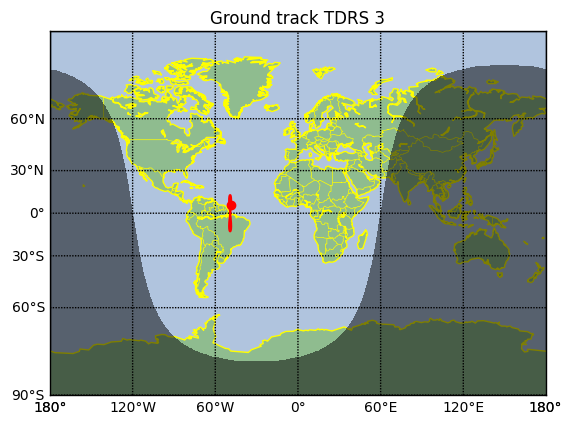

In [84]:
plt.figure()
map = Basemap(projection='mill',lon_0=0)
map.drawcoastlines(color="yellow")
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='lightsteelblue')
map.fillcontinents(color='darkseagreen',lake_color='lightsteelblue')
map.drawcountries(color="yellow")
# shade the night areas, with alpha transparency so the 
# map shows through. Use current time in UTC.
CS=map.nightshade(sat.d2)
x, y = map(lon_plot, lat_plot)
x_0, y_0 = map(lon_plot[0], lat_plot[0])
plt.plot(x, y, color="r")
plt.plot(x_0, y_0, color="r", marker="o")
plt.title(f"Ground track {sat.NAME}")
plt.show()